In [ ]:
import sys
print(sys.path)

Make sure you have the src file installed in your python path by excuting in a terminal for example ```pip install -e ``` the setup.py file shows which dir are installed in pythonpath so then you can just access any function in there by import $FILENAME.py

In [1]:
import os
import glob
from load_hdf5 import load_depth_maps_from_hdf5
import pandas as pd
input_map = "/tank/tgn252/metadata_annotations/result"
video_names = os.listdir(input_map)

data = {}



In [2]:
def find_files(video_name, dir_name, file_type, base_path="/tank/tgn252/metadata_annotations/result"):
    """
    Find all files of a given type in a specified directory (and its subdirectories) for a given video.

    Args:
        video_name (str): The name of the video.
        dir_name (str): The name of the directory to search.
        file_type (str): The type of the files to find (e.g., "csv" or "hdf5").
        base_path (str): The base path where the video directories are located.

    Returns:
        files (list): A list of paths to the files.
    """
    search_path = os.path.join(base_path, video_name, dir_name)
    files = glob.glob(os.path.join(search_path, f"**/*.{file_type}"), recursive=True)
    return files

In [ ]:
video_name = "R_S_comp_DB_D001_C001_PSNK_v06_SDR_PS_20180824_SDR_2K_AVC.mp4"
dir_name = "captioning"
file_type = "csv"
files = find_files(video_name, dir_name, file_type)

In [3]:

for video_name in video_names:
    video_data = {}
    # Load depth map from HDF5 file
        # Find CSV file in "captioning" subdirectory
    caption_csv = find_files(video_name, 'captioning', 'csv')
    if caption_csv:
        captions_df = pd.read_csv(caption_csv[0]) 
        # Extract the first caption
        caption = captions_df["Caption"].iloc[0]

        print(caption)
        video_data["caption"] = caption
    else:
        print(f"No CSV file found in captioning directory for video {video_name}")
        
    hdf5_files = find_files(video_name, 'depth_estimation', 'h5')
    if hdf5_files:
        depth_map = load_depth_maps_from_hdf5(hdf5_files[0])
        # print(f'{hdf5_files[0]} loaded')
        video_data["depth_map"] = depth_map
    else:
        print(f"No HDF5 file found for video {video_name}")

    data[video_name] = video_data


['a bear is sitting in the grass and then the camera pans to the camera.']
['a large body of water']
['a cliff is covered with moss and moss.']
['a man is holding a large fish in his hand']
['a scene outside']
['jelly fish are under water']
['a wall on the side of a building']
['a group of people are outside on fire and one is holding a bottle of liquid.']
['a woman is dancing in a dark room with a large amount of red and gold.']
['a woman is doing yoga in a park while a man is talking to her.']
['a man and a woman are sitting down']
['two puppies are chewing on a spoon and one of them licks the other.']
['a bridge is in the background']
['a person is playing with a stack of playing cards']
['a large crowd of people are cheering in a stadium.']
['a man is doing push ups on a bar in a gym.']
['a horse is running in a barn']
['a long silver train']
['a train is passing through tall grass.']
['a person is using a knife to cut a potato.']
['a man is shown walking across a body of alligator

First we create embeddings using word2vec, afterwards we average the depthmaps, we try different levels (whole video) and frame and then see how we can do CCA with that


In [4]:
import gensim.downloader as api
import numpy as np
import string

In [5]:
import importlib
import caption_to_embedding
from caption_to_embedding import transform_captions
importlib.reload(caption_to_embedding)

<module 'caption_to_embedding' from '/tank/tgn252/metadata_annotations/scripts/caption_to_embedding.py'>

In [6]:
model = api.load("glove-wiki-gigaword-100")

In [42]:

for video_name, values in data.items():
    caption = values["caption"]
    embeddings = transform_captions(caption, model)
    if len(embeddings) != 100:
        print(f"Embeddings for video {video_name} has length {len(embeddings)}, should match {model} length of 100")
    data[video_name]["embeddings"] = embeddings

Now the depthmaps are in a tensor with  shape (Frames, greyscale-value, height,width)

In [ ]:
max_depth_map_value = float('-inf')
min_depth_map_value = float('inf')

for video_name, values in data.items():
    depth_map = values["depth_map"]
    max_value = np.max(depth_map)
    if max_value > max_depth_map_value:
        max_depth_map_value = max_value
    if max_value < min_depth_map_value:
        min_depth_map_value = max_value

depth_map_range = max_depth_map_value - min_depth_map_value
print("Range of maximum depth_map values:", max_depth_map_value, min_depth_map_value
)


In [43]:
for video_name, values in data.items():
    depth_map = values["depth_map"]
    # Normalize the grayscale values between 0 and 255
    normalized_depth_map = (depth_map - np.min(depth_map)) * (255 / (np.max(depth_map) - np.min(depth_map)))
    # Compute the mean and standard deviation over all pixels
    mean_depth_map_pixels = np.mean(normalized_depth_map, axis=(2, 3))
    std_depth_map_pixels = np.std(normalized_depth_map, axis=(2, 3))
    # Standardize the depth map
    standardized_depth_map = (normalized_depth_map - mean_depth_map_pixels[:, :, None, None]) / std_depth_map_pixels[:, :, None, None]
    # Compute the mean over all frames
    mean_depth_map_frames = np.mean(standardized_depth_map, axis=(2, 3))
    # Add the mean depth map to the dictionary
    data[video_name]["stand_mean_depth_map"] = mean_depth_map_frames

In [57]:
from sklearn.preprocessing import StandardScaler

# Assume embeddings is a 2D array of shape (n_samples, n_features)

embeddings_standardized = StandardScaler().fit_transform(embeddings)
mean_depth_map_frames_standardized = StandardScaler().fit_transform(mean_depth_map_per_frames)
print(embeddings_standardized.shape)
print(mean_depth_map_frames_standardized.shape)


(56, 100)
(56, 150)


In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
# Standardize the embeddings and depth_maps
embeddings_standardized = embeddings_standardized
depth_maps_standardized = mean_depth_map_frames_standardized


# Create a CCA object
cca = CCA(n_components=2)

# Fit the CCA model to the standardized data
cca.fit(embeddings_standardized, depth_maps_standardized)

# Apply the CCA transformation to the standardized data
embeddings_c, depth_maps_c = cca.transform(embeddings_standardized, depth_maps_standardized)

# Compute the correlations
correlations = np.corrcoef(embeddings_c.T, depth_maps_c.T)

# Print the correlations
print("Correlations:")
print(correlations)


Correlations:
[[ 1.00000000e+00  1.49821898e-16  1.00000000e+00 -6.76611319e-08]
 [ 1.49821898e-16  1.00000000e+00  1.46033918e-10  1.00000000e+00]
 [ 1.00000000e+00  1.46033918e-10  1.00000000e+00 -6.75150982e-08]
 [-6.76611319e-08  1.00000000e+00 -6.75150982e-08  1.00000000e+00]]


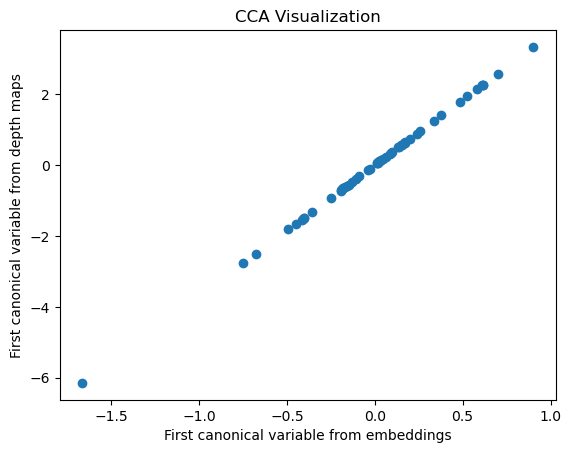

In [64]:
import matplotlib.pyplot as plt

# Scatter plot of the transformed data
plt.scatter(embeddings_c[:, 0], depth_maps_c[:, 0])
plt.xlabel('First canonical variable from embeddings')
plt.ylabel('First canonical variable from depth maps')
plt.title('CCA Visualization')
plt.show()


In [ ]:
print('Canonical correlations:', np.diag(cca.y_rotations_))
print('Canonical correlation:', canonical_correlation)


In [8]:
for video_name, values in data.items():
    depth_map = values["depth_map"]
    # Normalize the grayscale values between 0 and 255
    normalized_depth_map = (depth_map - np.min(depth_map)) * (255 / (np.max(depth_map) - np.min(depth_map)))
    # Compute the mean over all pixels
    print(normalized_depth_map)
    mean_depth_map_pixels = np.mean(normalized_depth_map, axis=(2, 3))
    # Compute the mean over all frames

    mean_depth_map_frames = np.mean(mean_depth_map_pixels)

    # Add the mean depth map to the dictionary
    data[video_name]["mean_depth_map"] = mean_depth_map_frames


[[[[ 12.178359   12.406629   12.572491  ...  10.222766   10.455231
     10.201461 ]
   [ 12.554721   12.512734   12.756326  ...  10.650131   10.548075
     10.659361 ]
   [ 13.073697   13.087292   13.290587  ...  11.180447   11.11544
     10.998352 ]
   ...
   [215.98056   216.67096   216.17479   ... 232.18608   232.17503
    232.39058  ]
   [217.30554   217.14458   217.1064    ... 231.98538   232.35031
    232.73155  ]
   [217.20996   217.44208   217.1322    ... 232.67151   233.4761
    233.22292  ]]]


 [[[ 12.132515   12.35969    12.524769  ...  10.268887   10.499976
     10.24306  ]
   [ 12.506242   12.464927   12.707664  ...  10.695683   10.592737
     10.705566 ]
   [ 13.031686   13.0401125  13.242984  ...  11.227161   11.161732
     11.045188 ]
   ...
   [216.0213    216.712     216.2157    ... 232.21704   232.20532
    232.42003  ]
   [217.34691   217.1861    217.14804   ... 232.01714   232.38194
    232.76082  ]
   [217.25185   217.48402   217.17409   ... 232.70322   233.5066


In [ ]:

for video_name, values in data.items():
    depth_map = values["depth_map"]
    # Compute the mean over the height and width dimensions, resulting in a tensor of shape (Frames, greyscale-value)
    mean_depth_map_per_frame = np.mean(depth_map, axis=(2, 3))
    # Then compute the mean over the frames dimension, resulting in a tensor of shape (greyscale-value)
    mean_depth_map_overall = np.mean(mean_depth_map_per_frame, axis=0)
    data[video_name]["mean_depth_value"] = mean_depth_map_overall
    


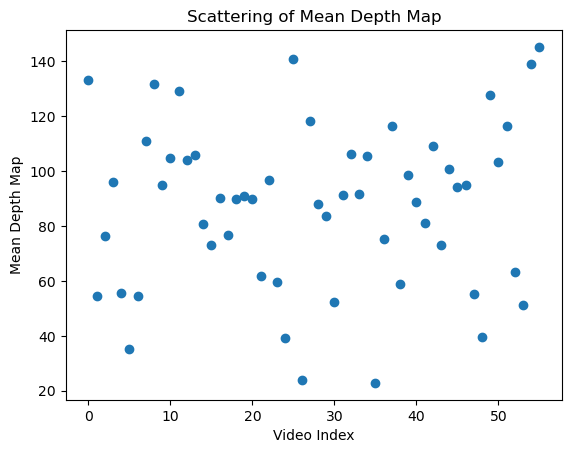

In [9]:
import matplotlib.pyplot as plt

# Create a list to store the mean depth map values
mean_depth_map_values = []

# Iterate over the data dictionary and extract the mean depth map values
for values in data.values():
    mean_depth_map_values.append(values["mean_depth_map"])

# Convert the list to a NumPy array
mean_depth_map_values = np.array(mean_depth_map_values)

# Scatter plot of the mean depth map values
plt.scatter(range(len(mean_depth_map_values)), mean_depth_map_values)
plt.xlabel('Video Index')
plt.ylabel('Mean Depth Map')
plt.title('Scattering of Mean Depth Map')
plt.show()


In [48]:
# Create a list for each set of variables
embeddings = []
depth_maps = []
shape = None
for video_name, values in data.items():
    if shape is None:
        shape = values["mean_depth_map"].shape
    if values["mean_depth_map"].shape == shape:
        depth_maps.append(values["mean_depth_map"])
        embeddings.append(values["embeddings"])

# Convert the lists to NumPy arrays
embeddings = np.array(embeddings)
depth_maps = np.array(depth_maps)

CCA wants 2D vectos, we represent them like this

In [49]:
print(embeddings.shape)
print(depth_maps.shape)

(56, 100)
(56,)


In [38]:
for map in depth_maps:
    print(map)

133.11273
54.385162
76.18863
95.88371
55.5442
35.10981
54.537663
111.01995
131.64151
94.753296
104.85744
129.12607
104.00214
105.85925
80.72054
73.203804
90.17944
76.74665
89.71584
90.69854
89.612656
61.70537
96.613464
59.52586
39.210327
140.70563
24.012943
118.09174
87.94937
83.708725
52.337124
91.14175
106.274506
91.42998
105.46704
22.852676
75.350174
116.2905
58.711563
98.427765
88.55657
81.19008
109.14406
73.16204
100.87444
94.12498
94.905
55.05164
39.52041
127.803635
103.1812
116.42696
63.21207
51.216686
138.79863
145.12238


In [18]:
import sklearn

In [19]:
from sklearn.cross_decomposition import CCA

# Create a CCA object
cca = CCA(n_components=1)

# Fit the CCA model to your data
cca.fit(embeddings, depth_maps)

# Apply the CCA transformation to your data
embeddings_c, depth_maps_c = cca.transform(embeddings, depth_maps)

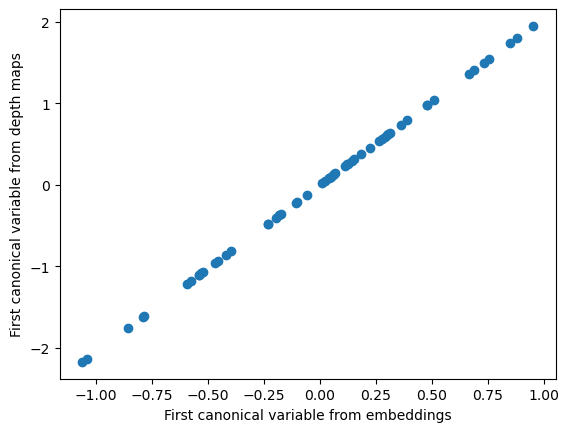

In [20]:
import matplotlib.pyplot as plt

plt.scatter(embeddings_c[:, 0], depth_maps_c[:, 0])
plt.xlabel('First canonical variable from embeddings')
plt.ylabel('First canonical variable from depth maps')
plt.show()

In [21]:
print('Canonical correlations:', np.diag(cca.y_rotations_))

Canonical correlations: [1.]


In [23]:
import numpy as np

# Compute the canonical correlations
canonical_correlations = [np.corrcoef(embeddings_c[:, i], depth_maps_c[:, i])[0,1] for i in range(embeddings_c.shape[1])]

print('Canonical correlations:', canonical_correlations)

Canonical correlations: [0.9999999999999996]


Okay so im confused about the almost perfect correlation, so I dont know what is going wrong so we try to do it not with the average of all pixels of all frames, but we cca with the 100 vector embedding with the average of frames creating two vectors of (video,100) and (videos,150)

In [39]:
# Iterate over the data dictionary and extract the depth maps

for i, values in enumerate(data.values()):
    depth_map = values["depth_map"]
    # Compute the mean over the height and width dimensions, resulting in a tensor of shape (Frames, greyscale-value)
    mean_depth_map_per_frame = np.mean(depth_map, axis=(2, 3))
    #
    # Add the mean depth map per frame to the data dictionary
    values["mean_depth_map_per_frame"] = mean_depth_map_per_frame
    print(mean_depth_map_per_frame.shape)




(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)


In [56]:
mean_depth_map_per_frames = []

for values in data.values():
    mean_depth_map_per_frame = values["mean_depth_map_per_frame"]
    
    # Ensure that mean_depth_map_per_frame is a 1D array of length 150
    mean_depth_map_per_frame = mean_depth_map_per_frame.flatten()[:150]
    
    mean_depth_map_per_frames.append(mean_depth_map_per_frame)

mean_depth_map_per_frames = np.array(mean_depth_map_per_frames)

print(mean_depth_map_per_frames.shape)

(56, 150)


In [41]:
from sklearn.cross_decomposition import CCA


embeddings = np.array([values["embeddings"] for values in data.values()])

# Create a CCA object
cca = CCA(n_components=50)

# Fit the CCA model to your data
cca.fit(mean_depth_map_per_frames, embeddings)

# Transform your data
mean_depth_map_per_frames_c, embeddings_c = cca.transform(mean_depth_map_per_frames, embeddings)

# Compute the canonical correlation
canonical_correlation = np.corrcoef(mean_depth_map_per_frames_c[:, 0], embeddings_c[:, 0])[0, 1]

print('Canonical correlation:', canonical_correlation)

Canonical correlation: 0.9999999999998074


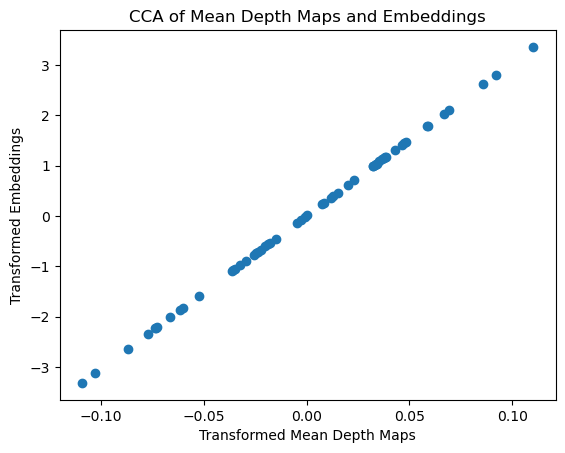

In [35]:
import matplotlib.pyplot as plt

# Scatter plot of the transformed data
plt.scatter(mean_depth_map_per_frames_c[:, 0], embeddings_c[:, 0])
plt.xlabel('Transformed Mean Depth Maps')
plt.ylabel('Transformed Embeddings')
plt.title('CCA of Mean Depth Maps and Embeddings')
plt.show()

-0.2193055786910179


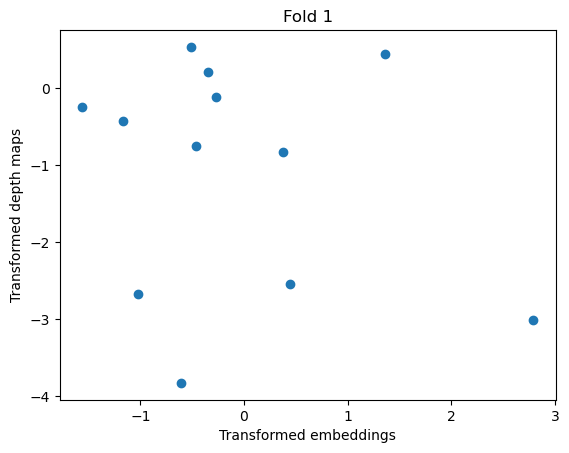

0.1556910402767355


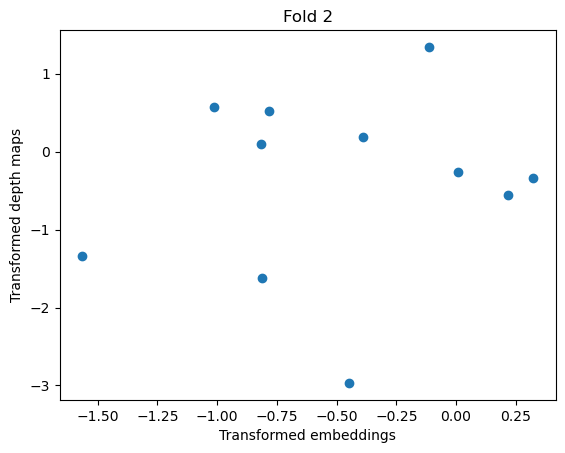

-0.0035413543664510635


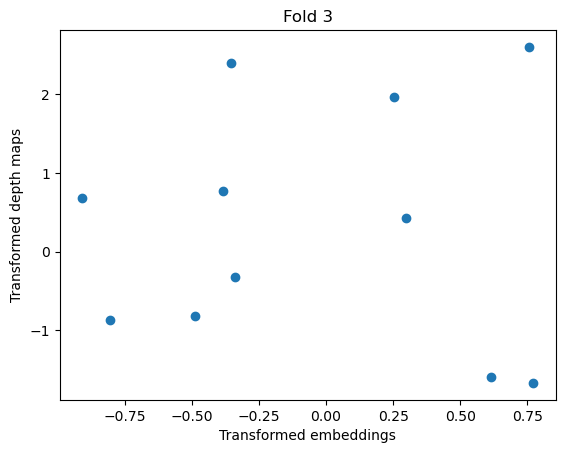

0.46014855581650993


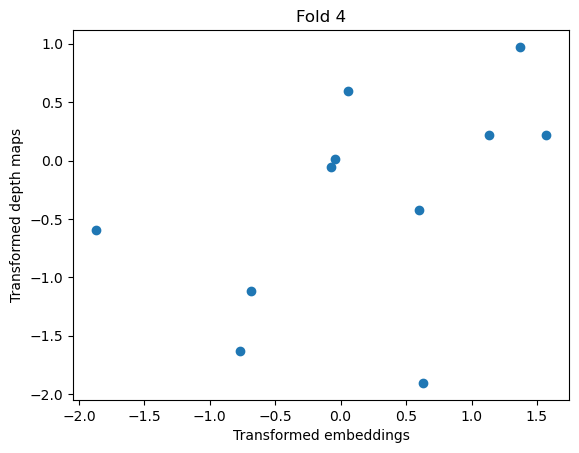

0.05616181287334029


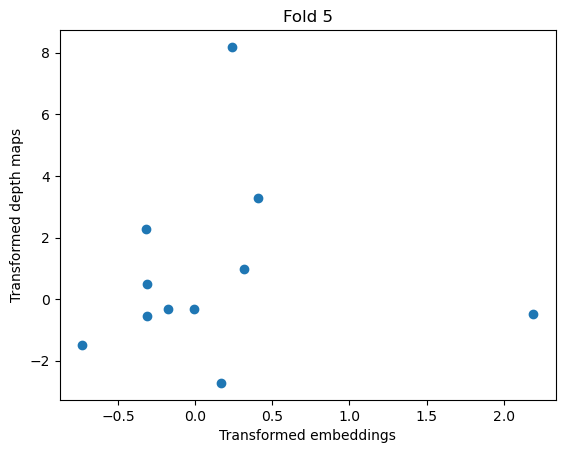

0.08983089518182334


In [70]:
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data is in 'embeddings' and 'depth_maps'
n_splits = 5  # For k-fold
kf = KFold(n_splits=n_splits)

canonical_correlations = []

for i, (train_index, test_index) in enumerate(kf.split(embeddings)):
    # Split data into training and test sets
    X_train, X_test = embeddings_standardized[train_index], embeddings_standardized[test_index]
    Y_train, Y_test = depth_maps_standardized[train_index], depth_maps_standardized[test_index]

    # Initialize and fit CCA
    cca = CCA(n_components=1)  # Choose appropriate number of components
    cca.fit(X_train, Y_train)

    # Transform both training and test sets
    X_train_c, Y_train_c = cca.transform(X_train, Y_train)
    X_test_c, Y_test_c = cca.transform(X_test, Y_test)

    # Calculate and store the canonical correlation for the test set
    test_correlation = np.corrcoef(X_test_c[:, 0], Y_test_c[:, 0])[0, 1]
    canonical_correlations.append(test_correlation)
    print(test_correlation)
    # Plot the transformed test set
    plt.figure(i)
    plt.scatter(X_test_c[:, 0], Y_test_c[:, 0])
    plt.title(f'Fold {i+1}')
    plt.xlabel('Transformed embeddings')
    plt.ylabel('Transformed depth maps')
    plt.show()

# Average canonical correlation across all folds
average_canonical_correlation = np.mean(canonical_correlations)
print(average_canonical_correlation)